In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Preparation

In [22]:
df = pd.read_csv("World_GDP_Data.csv")
df.head()

,Country Name,Country Code,Series Name,Series Code,1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,World,WLD,GDP (constant 2015 US$),NY.GDP.MKTP.KD,2.179668e+13,2.191148e+13,2.305400e+13,2.398041e+13,2.496102e+13,2.600499e+13,...,7.307523e+13,7.535966e+13,7.748522e+13,8.016639e+13,8.280115e+13,8.498894e+13,8.249703e+13,8.766122e+13,9.036960e+13,9.282706e+13
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

In [23]:
import pandas as pd

# Filter 'GDP (constant 2015 US$)' rows
gdp_df = df[df['Series Name'] == 'GDP (constant 2015 US$)']

# Melt all columns that have 'YR' in their name
melted_df = gdp_df.melt(id_vars=['Country Name'], 
                        value_vars=[col for col in df.columns if '[YR' in col],
                        var_name='Year', 
                        value_name='GDP')

# extract just the year number
melted_df['Year'] = melted_df['Year'].str.extract(r'(\d{4})')

# Pivot DataFrame to make 'Country Name' as columns
df = melted_df.pivot(index='Year', columns='Country Name', values='GDP')

# Rename columns to include 'GDP'
df.columns = ['GDP ' + col for col in df.columns]
df

,GDP World
Year,
1974,2.179668e+13
1975,2.191148e+13
1976,2.305400e+13
1977,2.398041e+13
1978,2.496102e+13
1979,2.600499e+13
1980,2.649429e+13
1981,2.700468e+13
1982,2.708475e+13


<AxesSubplot:xlabel='Year'>

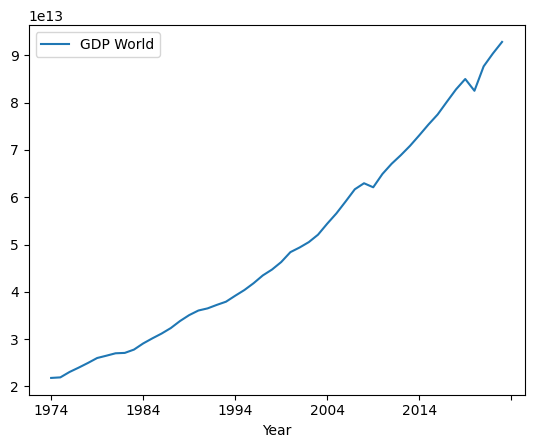

In [24]:
df.plot()

<AxesSubplot:xlabel='Year'>

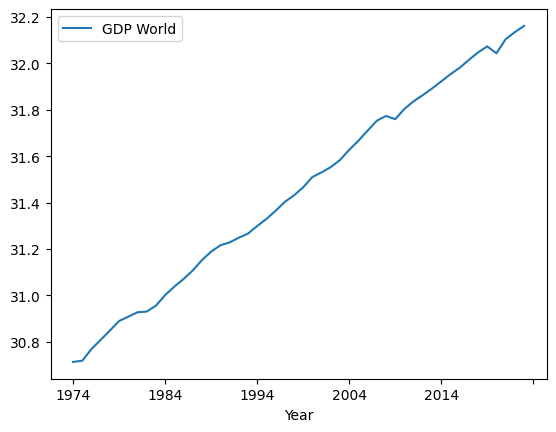

In [25]:
df = np.log(df)
df.plot()

In [27]:
df.reset_index(inplace=True)
msk = (df.index < len(df)-13)
df_train = df[msk].copy()
df_test = df[~msk].copy()

print(f'train length: {len(df_train)} & test length: {len(df_test)}')

train length: 37 & test length: 13


# Check ACF and PACF

In [28]:
df_train

,Year,GDP World
0,1974,30.712779
1,1975,30.718032
2,1976,30.768861
3,1977,30.808258
4,1978,30.848337
5,1979,30.889309
6,1980,30.907950
7,1981,30.927031
8,1982,30.929992
9,1983,30.955525


C:\Users\GF63\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


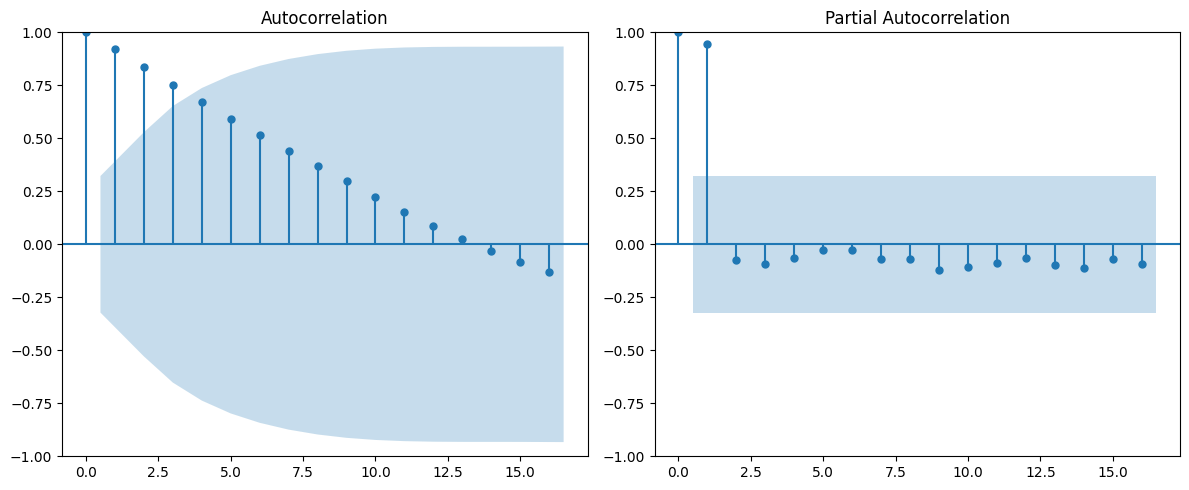

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(df_train['GDP World'], ax=ax[0])
plot_pacf(df_train['GDP World'], ax=ax[1])

plt.tight_layout()
plt.show()

In [32]:
adf_test = adfuller(df_train['GDP World'])
print(f'p-value: {adf_test[1]}')

p-value: 0.9485166086166579


# Make them to Stationary (Diff)

In [34]:
df_train_diff = df_train['GDP World'].diff().dropna()
df_train_diff

1     0.005253
2     0.050829
3     0.039398
4     0.040078
5     0.040973
6     0.018641
7     0.019081
8     0.002961
9     0.025533
10    0.045684
11    0.036359
12    0.032964
13    0.036569
14    0.044894
15    0.036498
16    0.027270
17    0.012480
18    0.019991
19    0.017967
20    0.032699
21    0.030380
22    0.035123
23    0.038545
24    0.028140
25    0.034882
26    0.044314
27    0.020052
28    0.022767
29    0.030571
30    0.043723
31    0.039277
32    0.043469
33    0.042803
34    0.020415
35   -0.013651
36    0.044300
Name: GDP World, dtype: float64

<AxesSubplot:>

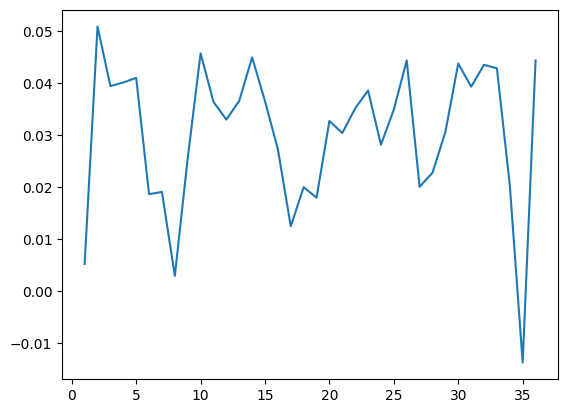

In [35]:
df_train_diff.plot()

C:\Users\GF63\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


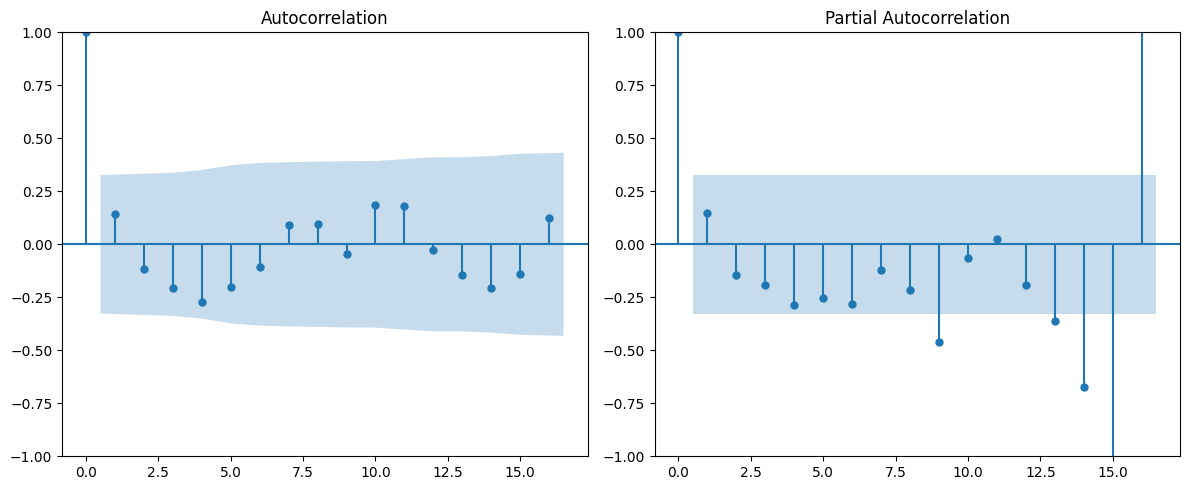

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(df_train_diff, ax=ax[0])
plot_pacf(df_train_diff, ax=ax[1])

plt.tight_layout()
plt.show()

In [39]:
adf_test_diff = adfuller(df_train_diff)
print(f'p-value: {adf_test_diff[1]}')

p-value: 0.0003519220016179863


# Model Fit

## Fit to ARIMA Model

In [66]:
model = ARIMA(df_train['GDP World'], order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              GDP World   No. Observations:                   37
Model:                 ARIMA(5, 1, 0)   Log Likelihood                  97.957
Date:                Wed, 25 Sep 2024   AIC                           -183.914
Time:                        15:42:58   BIC                           -174.413
Sample:                             0   HQIC                          -180.598
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5568      0.186      2.986      0.003       0.191       0.922
ar.L2         -0.0549      0.338     -0.163      0.871      -0.717       0.607
ar.L3          0.1987      0.378      0.525      0.5

### Model Specification

- **Dep. Variable**: This indicates the dependent variable, which is `'GDP World'` in this case.
- **No. Observations**: The total number of observations used in the model is 37.
- **Model**: The model is specified as **ARIMA(1,0,0)**, meaning it has an autoregressive term of order 1 (AR(1)), no differencing (d=0), and no moving average terms (MA=0).
- **Covariance Type**: Refers to how the standard errors are computed. In this case, it is `'opg'` (outer product of gradients).

### Log Likelihood

- **Log Likelihood**: This is a measure of how well the model fits the data. **A higher value indicates a better fit**. For this model, it is **70.260**.

### Model Selection Criteria

- **AIC** (Akaike Information Criterion): A lower AIC value indicates a better-fitting model. For this model, the AIC is **-134.520**.
- **BIC** (Bayesian Information Criterion): Similar to AIC but with a higher penalty for model complexity. Here, the BIC is **-129.687**.
- **HQIC** (Hannan-Quinn Information Criterion): Another criterion like AIC and BIC, with a different penalty structure. HQIC is **-132.816**.

Typically, lower values for AIC, BIC, and HQIC indicate a better model, balancing goodness-of-fit with complexity.

### Model Coefficients

- **const (31.2580)**: This is the constant or intercept term of the model. It indicates the base level of `'GDP World'` when other factors (in this case, the AR term) are zero.
  - **z-score (60.013)**: A very high z-score suggests that this coefficient is highly significant.
  - **P>|z| (0.000)**: This is the p-value for the constant term, and since it is less than 0.05, it is highly significant.

- **ar.L1 (0.9947)**: This is the coefficient for the first lag of the autoregressive term (AR(1)). It is very close to 1, suggesting a strong persistence in the time series.
  - **z-score (61.895)**: A very high z-score, indicating this coefficient is also highly significant.
  - **P>|z| (0.000)**: Again, the p-value is very small, so the AR(1) term is statistically significant.

- **sigma² (0.0012)**: This is the variance of the residuals (errors). A small sigma² indicates the residual variance is low, which is good for model fit.
  - **P>|z| (0.080)**: The p-value is slightly above 0.05, indicating marginal significance for the residual variance.

### Diagnostics

- **Ljung-Box (L1) (Q): 2.20**: This is a test statistic for autocorrelation in the residuals. A significant result (low p-value) would indicate that there is autocorrelation in the residuals, which the model failed to capture. In this case, the p-value (Prob(Q)) is **0.14**, which suggests no significant autocorrelation at lag 1.

- **Jarque-Bera (JB): 108.38**: This test assesses whether the residuals follow a normal distribution. A high JB value with a low p-value (here, 0.00) indicates that the residuals deviate from normality, which is something to be cautious about.

- **Heteroskedasticity (H): 1.15**: This tests for heteroskedasticity (non-constant variance) in the residuals. A value close to 1 and a high p-value (0.81) indicate no significant heteroskedasticity.

- **Skew (-2.32)**: The residuals are negatively skewed, which may indicate an asymmetry in the data.

- **Kurtosis (9.99)**: The residuals exhibit high kurtosis, suggesting that there are more extreme values (heavy tails) than would be expected under a normal distribution.

### Summary of the Model

- The model fits the data well based on the AIC and BIC values, and the autoregressive term (AR(1)) is highly significant.
- However, the **Jarque-Bera test** suggests that the residuals are not normally distributed, which could indicate that the model may not fully capture some aspect of the data.
- No significant autocorrelation was found in the residuals, meaning the model adequately captured the time dependencies.

### Overall:
- The AR(1) model seems appropriate for the time series based on the AR term and model diagnostics.
- However, the non-normality of residuals could signal that there might be additional factors or transformations that could further improve the model fit.


## Visualize the Residu

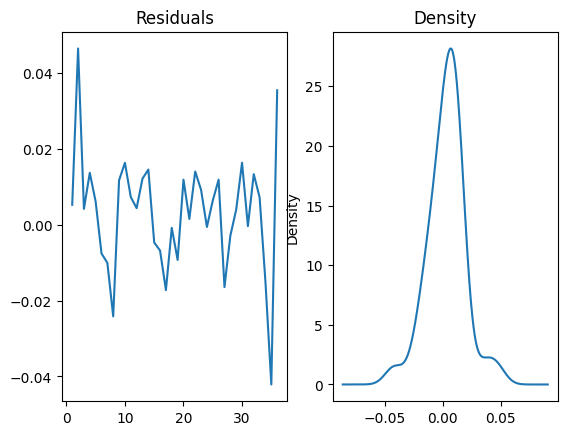

In [67]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

C:\Users\GF63\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


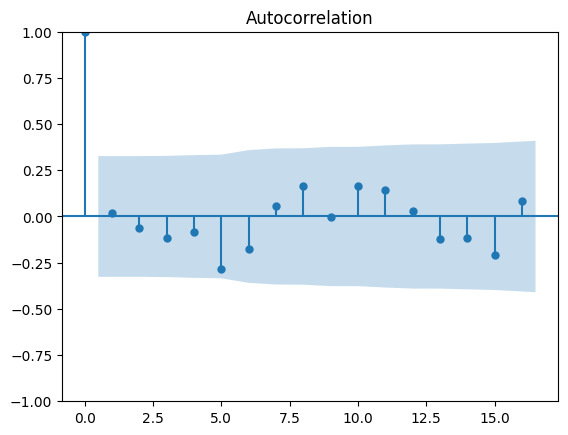

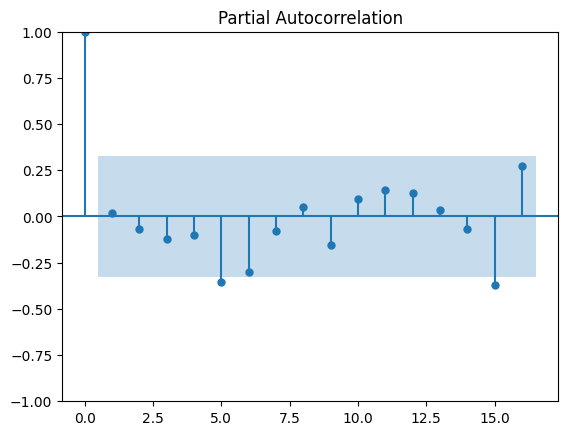

In [68]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

# Visualize Result

<AxesSubplot:>

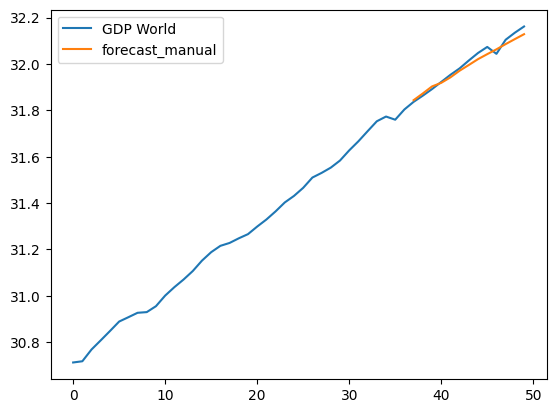

In [69]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df.plot()

# Forecast the next 5 years

In [158]:
forecast_years = 6
forecast_new = model_fit.forecast(steps=forecast_years).values

forecast_new

array([31.84393447, 31.87297011, 31.90323548, 31.91873271, 31.94240327,
       31.97113059])

In [159]:
future_index = pd.date_range(start=df.index[-1] + pd.DateOffset(1), periods=forecast_years, freq='Y')
forecast_df = pd.DataFrame(data = forecast_new, index=future_index, columns=['GDP World forecast'])

forecast_df

,GDP World forecast
2023-12-31,31.843934
2024-12-31,31.872970
2025-12-31,31.903235
2026-12-31,31.918733
2027-12-31,31.942403
2028-12-31,31.971131


In [160]:
df_with_forecast = pd.concat([df, forecast_df])

df_with_forecast

,GDP World,forecast_manual,GDP World forecast
1974-01-01,30.712779,NaN,NaN
1975-01-01,30.718032,NaN,NaN
1976-01-01,30.768861,NaN,NaN
1977-01-01,30.808258,NaN,NaN
1978-01-01,30.848337,NaN,NaN
1979-01-01,30.889309,NaN,NaN
1980-01-01,30.907950,NaN,NaN
1981-01-01,30.927031,NaN,NaN
1982-01-01,30.929992,NaN,NaN
1983-01-01,30.955525,NaN,NaN


In [161]:
df_with_forecast.drop(pd.Timestamp('2023-12-31'), inplace=True)
df_with_forecast.index = df_with_forecast.index.year
df_with_forecast.head()

,GDP World,forecast_manual,GDP World forecast
1974,30.712779,NaN,NaN
1975,30.718032,NaN,NaN
1976,30.768861,NaN,NaN
1977,30.808258,NaN,NaN
1978,30.848337,NaN,NaN


In [162]:
df_with_forecast = df_with_forecast.reset_index()

In [163]:
df_with_forecast.rename(columns={'index': 'year'}, inplace=True)
df_with_forecast

,year,GDP World,forecast_manual,GDP World forecast
0,1974,30.712779,NaN,NaN
1,1975,30.718032,NaN,NaN
2,1976,30.768861,NaN,NaN
3,1977,30.808258,NaN,NaN
4,1978,30.848337,NaN,NaN
5,1979,30.889309,NaN,NaN
6,1980,30.907950,NaN,NaN
7,1981,30.927031,NaN,NaN
8,1982,30.929992,NaN,NaN
9,1983,30.955525,NaN,NaN


In [165]:
df_with_forecast[['year', 'GDP World', 'GDP World forecast']].to_csv('GDP World Forecast.csv', index=False)